# Influencia del algortimo a la hora de comprimir en Blosc

## Definición de la función

In [5]:
from transform_data import ffi, lib

def t_data(src, dest, sub_shape, inverse=False):

    typesize = src.dtype.itemsize

    src2 = ffi.from_buffer(src)
    dest2 = ffi.from_buffer(dest)

    shape = src.shape

    dimension = len(src.shape)

    lib.transform_data(src2, dest2, typesize, sub_shape, shape, dimension, inverse)

In [13]:
% matplotlib inline

import pycblosc2 as cb2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycblosc2 as cb2
import time as t

KB = 1024
MB = 1024 * KB
GB = 1024 * MB

A, B, C = 150, 238, 81

CHUNKSIZE = A * B * C
BLOSC_MAX_FILTERS = 5

src = np.arange(CHUNKSIZE, dtype=np.int32).reshape(A, B, C)
dest = np.empty(CHUNKSIZE, dtype=src.dtype).reshape(A, B, C)

tsize = src.dtype.itemsize
isize = CHUNKSIZE * tsize

dsize = 0

cparams = cb2.blosc2_create_cparams(compcode=4, clevel=5, use_dict=0, typesize=tsize,
                                    nthreads=4, blocksize=16 * KB, schunk=None,
                                    filters=[0, 0, 0, 0, 0],
                                    filters_meta=[0, 0, 0, 0, 0])

dparams = cb2.blosc2_create_dparams(nthreads=1, schunk=None)

sub_shapes = [[1, 1, 1], [15, 14, 27], [5, 14, 3], [75, 119, 81], [2, 2, 3]]

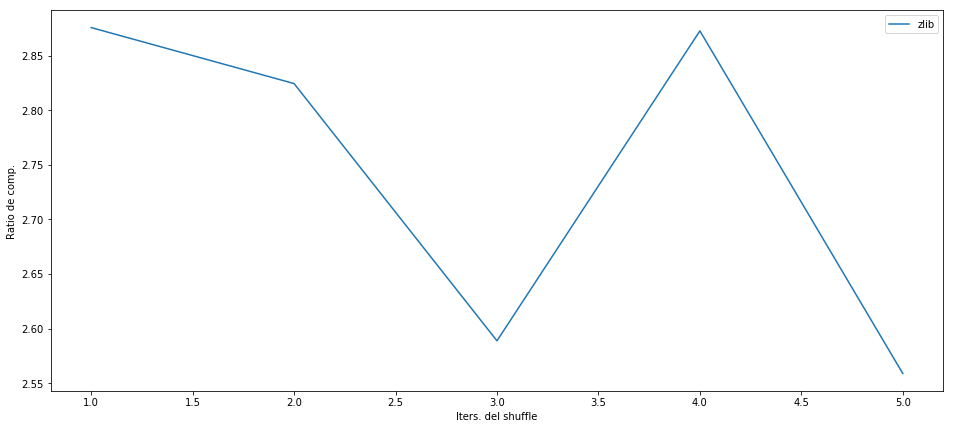

In [14]:
fig = plt.figure(figsize=(16, 7))
n = []
ratio = []
speed = [] 
for i, sub in enumerate(sub_shapes):
    
    start = t.perf_counter()
    
    t_data(src, dest, sub)
    
    schunk = cb2.blosc2_new_schunk(cparams, dparams)
    nchunks = cb2.blosc2_append_buffer(schunk, isize, dest)
    nbytes = schunk.nbytes
    cbytes = schunk.cbytes

    end = t.perf_counter()
    ttotal = end - start

    r = (1. * nbytes) / cbytes
    s = nbytes / (ttotal * MB)

    n.append(i+1)
    ratio.append(r)
    speed.append(s)

    cb2.blosc2_free_schunk(schunk)

plt.plot(n, ratio, label=cb2.blosc_compcode_to_compname(4)[1])

plt.ylabel("Ratio de comp.")
plt.xlabel("Iters. del shuffle")
plt.legend(loc = "upper right")

plt.show()